In [23]:
!pip install gymnasium[toy_text]
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Action: 1 

Observation: (14, 5, False) 
Reward: 0.0 
Done: False 
Info: {} 

Action: 1 

Observation: (24, 5, False) 
Reward: -1.0 
Done: True 
Info: {'TimeLimit.truncated': False} 



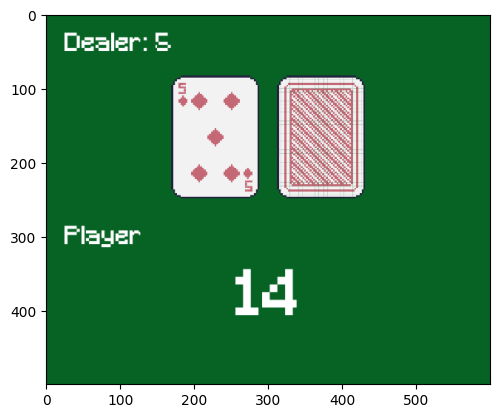

In [24]:
# Example of the Blackjack environment
import gym
import matplotlib.pyplot as plt

env = gym.make("Blackjack-v1")

observation = env.reset()

fig, ax = plt.subplots()

while True:
  ax.imshow(env.render(mode="rgb_array"))

  action = env.action_space.sample()
  print("Action:", action, "\n")

  observation, reward, done, info = env.step(action)
  print("Observation:", observation, "\nReward:", reward, "\nDone:", done, "\nInfo:", info, "\n")

  if done:
    break

n_actions = env.action_space.n
state = env.reset()
n_observations = len(state)

env.close()

plt.show()


In [25]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("Blackjack-v1")

is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# check whether GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [26]:
# Define the Deep Neural Network model
class DQN(nn.Module):
  
  def __init__(self, n_observations, n_actions):
    super(DQN, self).__init__()
    self.layer1 = nn.Linear(n_observations, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, n_actions)

  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(x)

    x = self.layer2(x)
    x = F.relu(x)

    x  = self.layer3(x)

    return x

In [27]:
# set hyper-parameters
gamma = 0.99
epsilon = 1
eps_end = 0.01
eps_dec = 5e-4
learning_rate = 0.001
batch_size = 64
mem_size = 100000


action_space = [i for i in range(n_actions)]
mem_counter = 0

Q_eval = DQN(n_observations, n_actions).to(device)
print(Q_eval)

optimizer = optim.Adam(Q_eval.parameters(), lr = learning_rate)
loss = nn.MSELoss()

input_dims = [n_observations]

state_memory = np.zeros((mem_size, *input_dims),dtype=np.float32)
new_state_memory = np.zeros((mem_size, *input_dims), dtype=np.float32)
action_memory = np.zeros(mem_size, dtype=np.int32)
reward_memory = np.zeros(mem_size, dtype=np.float32)
terminal_memory = np.zeros(mem_size, dtype=np.bool)

# define the transition function of the state to the memory
def store_transition(state, action, reward, new_state, done):
  global mem_counter
  index = mem_counter % mem_size
  state_memory[index] = state
  new_state_memory[index] = new_state
  reward_memory[index] = reward
  action_memory[index] = action
  terminal_memory[index] = done

  mem_counter += 1

# choosing action between exploration & exploitation
def choose_action(observation, epsilon):
  if np.random.random() > epsilon:
    state = torch.tensor([observation]).to(device)
    actions = Q_eval.forward(state.to(torch.float32))
    action = torch.argmax(actions).item()
  else:
    action = np.random.choice(action_space)
  return action

# training the model by computing the Q-value and loss function, by applying backpropagation and optimizer
def training(loss, eps_dec, eps_end):
  if mem_counter < batch_size:
    return

  optimizer.zero_grad()

  max_mem = min(mem_counter, mem_size)
  batch = np.random.choice(max_mem, batch_size, replace=False)

  batch_index = np.arange(batch_size)

  state_batch = torch.tensor(state_memory[batch]).to(device)
  new_state_batch = torch.tensor(new_state_memory[batch]).to(device)
  reward_batch = torch.tensor(reward_memory[batch]).to(device)
  terminal_batch = torch.tensor(terminal_memory[batch]).to(device)

  action_batch = action_memory[batch]

  q_eval = Q_eval.forward(state_batch)[batch_index, action_batch]
  q_next = Q_eval.forward(new_state_batch)
  q_next[terminal_batch] = 0.0

  q_target = reward_batch + gamma * torch.max(q_next, dim=1)[0]

  loss = loss(q_target, q_eval).to(device)
  loss.backward()
  optimizer.step()
  global epsilon
  epsilon = epsilon - eps_dec if epsilon > eps_end else eps_end
 

DQN(
  (layer1): Linear(in_features=3, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=2, bias=True)
)


<ipython-input-27-9ce29e978ac4>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  terminal_memory = np.zeros(mem_size, dtype=np.bool)


In [28]:
# repeat the training process over number of iterations
scores, eps_history, average_scores, winning_rate = [], [], [], []
if torch.cuda.is_available():
  n_games = 20000
else:
  n_games = 5000

for i in range(n_games):
  score = 0
  done = False
  observation = env.reset()
  while not done:
    action = choose_action(observation, epsilon)
    new_observation, reward, done, info = env.step(action)
    score += reward
    store_transition(observation, action, reward, new_observation, done)
    training(loss, eps_dec, eps_end)
    observation = new_observation
  scores.append(score)
  eps_history.append(epsilon)

  avg_score = np.mean(scores[-100:])
  average_scores.append(avg_score)

  winning_rate.append(scores.count(1)/len(scores))

  print("Episode ", i, "score %.2f" % score, "average score %.2f" % avg_score, "epsilon %.2f" % epsilon)

Episode  0 score -1.00 average score -1.00 epsilon 1.00
Episode  1 score -1.00 average score -1.00 epsilon 1.00
Episode  2 score -1.00 average score -1.00 epsilon 1.00
Episode  3 score -1.00 average score -1.00 epsilon 1.00
Episode  4 score 0.00 average score -0.80 epsilon 1.00
Episode  5 score 1.00 average score -0.50 epsilon 1.00
Episode  6 score 1.00 average score -0.29 epsilon 1.00
Episode  7 score 1.00 average score -0.12 epsilon 1.00
Episode  8 score 1.00 average score 0.00 epsilon 1.00
Episode  9 score -1.00 average score -0.10 epsilon 1.00
Episode  10 score -1.00 average score -0.18 epsilon 1.00
Episode  11 score -1.00 average score -0.25 epsilon 1.00
Episode  12 score 1.00 average score -0.15 epsilon 1.00
Episode  13 score -1.00 average score -0.21 epsilon 1.00
Episode  14 score 1.00 average score -0.13 epsilon 1.00
Episode  15 score -1.00 average score -0.19 epsilon 1.00
Episode  16 score -1.00 average score -0.24 epsilon 1.00
Episode  17 score 1.00 average score -0.17 epsilo

The total average score is -0.1322
The winning rate is 39.58% 
The drawing rate is 7.62% 
The losing rate is 52.800000000000004% 



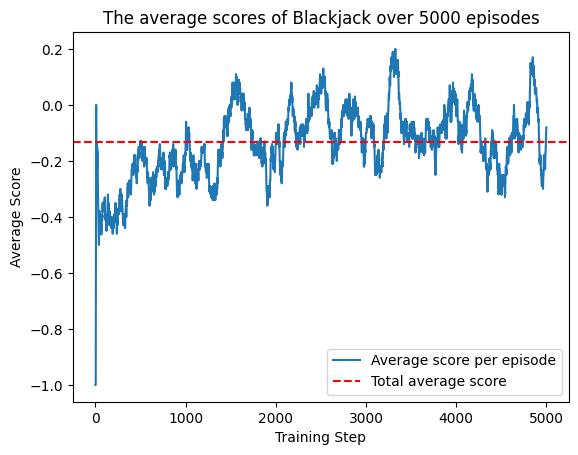

In [29]:
# return results and plot graphs
x = [i+1 for i in range(n_games)]
average = np.mean(scores)
print("The total average score is", average)

win_rate = scores.count(1)/len(scores)
draw_rate = scores.count(0)/len(scores)
lose_rate = scores.count(-1)/len(scores)
print("The winning rate is {}% \nThe drawing rate is {}% \nThe losing rate is {}% \n".format(win_rate*100, draw_rate*100, lose_rate*100))

plt.plot(x, average_scores, label="Average score per episode")
plt.axhline(y=average, color="r", linestyle="dashed", label="Total average score")
plt.xlabel("Training Step")
plt.ylabel("Average Score")
plt.title("The average scores of Blackjack over {} episodes".format(n_games))
plt.legend()


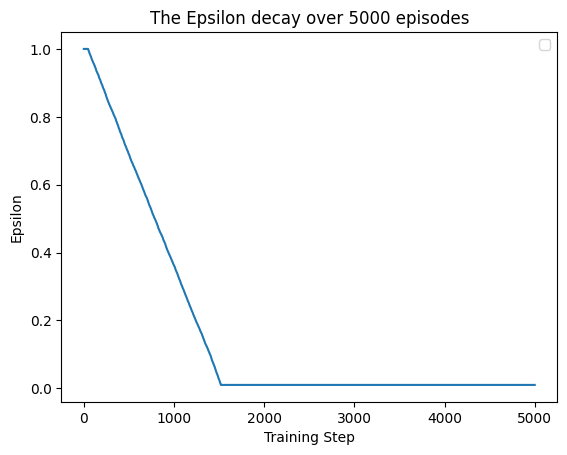

In [30]:

plt.plot(x, eps_history)
plt.xlabel("Training Step")
plt.ylabel("Epsilon")
plt.title("The Epsilon decay over {} episodes".format(n_games))
plt.legend()

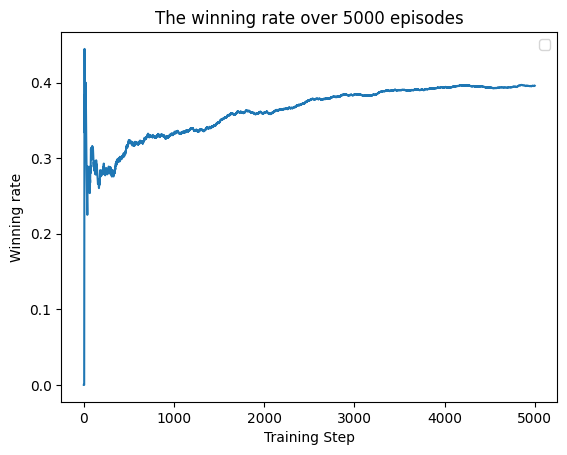

In [31]:
plt.plot(x, winning_rate)
plt.xlabel("Training Step")
plt.ylabel("Winning rate")
plt.title("The winning rate over {} episodes".format(n_games))
plt.legend()